In [0]:
import skimage.data
# Reading the image
img = skimage.data.chelsea()
# Converting the image into gray.
img = skimage.color.rgb2gray(img)

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

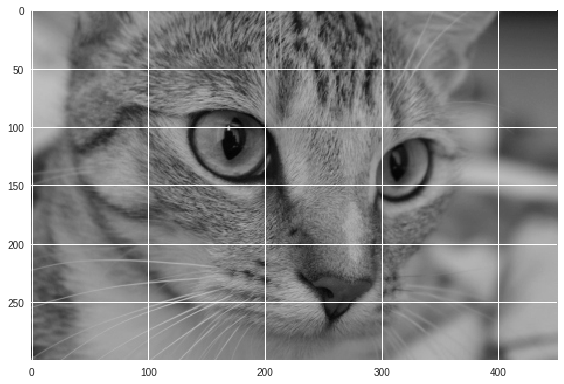

In [40]:
from matplotlib import pyplot as plt
from skimage import data, io

io.imshow(img)
plt.show()

In [170]:
img.shape

(300, 451)

In [0]:
import numpy as np
l1_filter = np.zeros((2,3, 3))

In [0]:
l1_filter[0, :, :] = np.array([[[-1, 0, 1],
                                [-1, 0, 1],
                                [-1, 0, 1]]])

In [0]:
l1_filter[1, :, :] = np.array([[[1,   1,  1],
                                   [0,   0,  0],
                                   [-1, -1, -1]]])

In [0]:
l1_filter = np.random.rand(1, 3, 3)

In [0]:
import sys
def conv(img, conv_filter):
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    feature_maps = np.zeros((img.shape[0]-conv_filter.shape[1]+1, 
                             img.shape[1]-conv_filter.shape[1]+1, 
                             conv_filter.shape[0]))

    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        print("Filter ", filter_num + 1)
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
        """ 
        Checking if there are mutliple channels for the single filter.
        If so, then each channel will convolve the image.
        The result of all convolutions are summed to return a single feature map.
        """
        if len(curr_filter.shape) > 2:
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.
                conv_map = conv_map + conv_(img[:, :, ch_num], 
                                  curr_filter[:, :, ch_num])
        else: # There is just a single channel in the filter.
            conv_map = conv_(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.

In [0]:
def conv_(img, conv_filter):
    filter_size = conv_filter.shape[1]
    result = np.zeros((img.shape))
    #Looping through the image to apply the convolution operation.
    for r in np.uint16(np.arange(filter_size/2.0, 
                          img.shape[0]-filter_size/2.0+1)):
        for c in np.uint16(np.arange(filter_size/2.0, 
                                           img.shape[1]-filter_size/2.0+1)):
            """
            Getting the current region to get multiplied with the filter.
            How to loop through the image and get the region based on 
            the image and filer sizes is the most tricky part of convolution.
            """
            curr_region = img[r-np.uint16(np.floor(filter_size/2.0)):r+np.uint16(np.ceil(filter_size/2.0)), 
                              c-np.uint16(np.floor(filter_size/2.0)):c+np.uint16(np.ceil(filter_size/2.0))]
            #Element-wise multipliplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result) #Summing the result of multiplication.
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.
            
    #Clipping the outliers of the result matrix.
    final_result = result[np.uint16(filter_size/2.0):result.shape[0]-np.uint16(filter_size/2.0), 
                          np.uint16(filter_size/2.0):result.shape[1]-np.uint16(filter_size/2.0)]
    return final_result

In [251]:
l1_feature_map = conv(img, l1_filter)

Filter  1


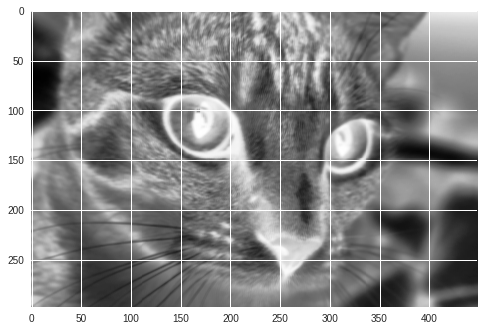

In [252]:
import matplotlib.pyplot as plt
arr = np.resize((l1_feature_map), (l1_feature_map.shape[0], l1_feature_map.shape[1]))
plt.imshow(arr)
plt.show()

In [253]:
l1_feature_map[0].shape

(449, 1)

In [0]:
def ReLU(x, h = None, derivative=False):
  if derivative:
    return x[h < 0]
  x_relu = np.maximum(x, 0)
  return x_relu

In [0]:
def sigmoid(x, derivative=False):
    """
Parameters:
    x: input
    derivative: boolean to specify if the derivative of the function should be computed
    """
    if derivative:
        return (x*(1-x))
    return (1/(1+np.exp(-x)))

In [0]:
def relu(feature_map):
    #Preparing the output of the ReLU activation function.
    relu_out = np.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in np.arange(0,feature_map.shape[0]):
            for c in np.arange(0, feature_map.shape[1]):
                img_proc[r, c, map_num] = sigmoid(feature_map[r, c, map_num])
    return img_proc

In [0]:
l1_feature_map_relu = relu(l1_feature_map)

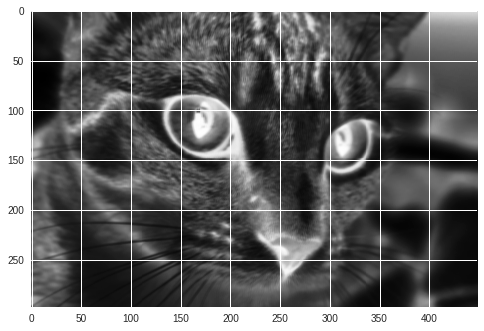

In [261]:
arr = np.resize((l1_feature_map_relu), (l1_feature_map_relu.shape[0], l1_feature_map_relu.shape[1]))
plt.imshow(arr)
plt.show()

In [0]:
def pooling(feature_map, size=2, stride=2):
    #Preparing the output of the pooling operation.
    pool_out = np.zeros((np.uint16((feature_map.shape[0]-size+1)/stride),
                            np.uint16((feature_map.shape[1]-size+1)/stride),
                            feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in np.arange(0,feature_map.shape[0]-size-1, stride):
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size-1, stride):
                pool_out[r2, c2, map_num] = np.max([feature_map[r:r+size,  c:c+size]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

In [0]:
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)

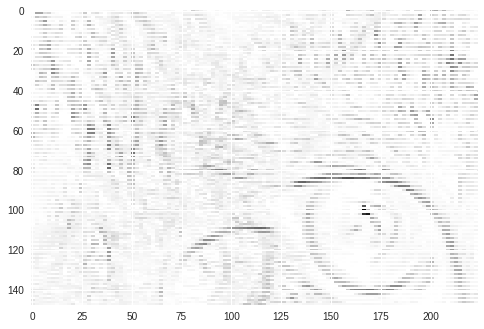

In [118]:
arr = np.resize((l1_feature_map_relu_pool), (l1_feature_map_relu_pool.shape[0], l1_feature_map_relu_pool.shape[1]))
plt.imshow(arr)
plt.show()

In [120]:
# Second conv layer
l2_filter = np.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])
print("\n**Working with conv layer 2**")
l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
print("\n**ReLU**")
l2_feature_map_relu = relu(l2_feature_map)
print("\n**Pooling**")
l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)
print("**End of conv layer 2**\n")


**Working with conv layer 2**
Filter  1
Filter  2
Filter  3

**ReLU**

**Pooling**
**End of conv layer 2**



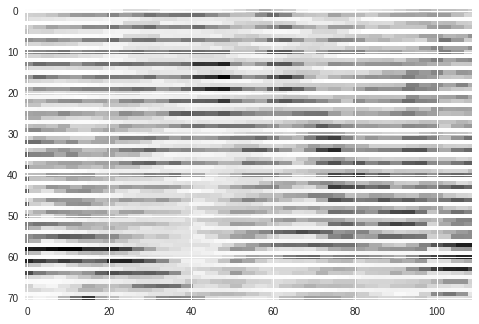

In [122]:
arr = np.resize((l2_feature_map_relu_pool), (l2_feature_map_relu_pool.shape[0], l2_feature_map_relu_pool.shape[1]))
plt.imshow(arr)
plt.show()

In [121]:
# Third conv layer
l3_filter = np.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])
print("\n**Working with conv layer 3**")
l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)
print("\n**ReLU**")
l3_feature_map_relu = relu(l3_feature_map)
print("\n**Pooling**")
l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)
print("**End of conv layer 3**\n")


**Working with conv layer 3**
Filter  1

**ReLU**

**Pooling**
**End of conv layer 3**



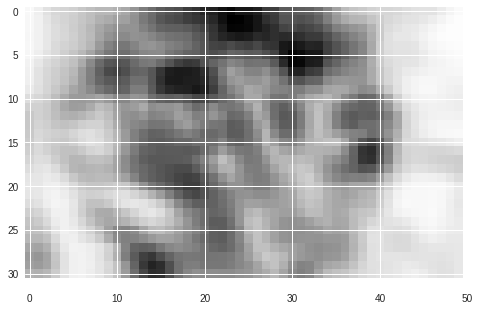

In [123]:
arr = np.resize((l3_feature_map_relu_pool), (l3_feature_map_relu_pool.shape[0], l3_feature_map_relu_pool.shape[1]))
plt.imshow(arr)
plt.show()